In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
import matplotlib

In [3]:
data_dir = '../../../data/'

In [4]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [5]:
with open('rh_betas_by_repeat_by_ROI.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [6]:
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = '../../../local_data/freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

In [7]:
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [8]:
# let's organize so we just have the ventral ROI
vent_idx = 5
sh_by_ROI = [[] for i in range(len(subjid))]
total_vox = np.zeros(len(subjid))

for sidx, sid in enumerate(subjid):  
    
    sh_by_ROI[sidx]=reliability[sidx][:,rh_streams[sidx] == vent_idx]
    total_vox[sidx] = len(sh_by_ROI[sidx][0])

In [9]:
sh_by_ROI[0].shape

(1, 16243)

In [10]:
#gotta be a better way to do this?
betas_by_repeat_VTC = [[[] for i in range(n_repeats)] for j in range(len(subjid))]
for sidx, sid in enumerate(subjid):  
    for r in range(3):   
        betas_by_repeat_VTC[sidx][r] = rh_betas_by_repeat_by_ROI[sidx][vent_idx-1][r]

In [11]:
betas_by_repeat_VTC[0][0].shape

(515, 16243)

In [12]:
thresh = 0.2 #start here

betas_by_repeat_VTC_trimmed = betas_by_repeat_VTC

for sidx, sid in enumerate(subjid):  
    for vox in range(len(sh_by_ROI[sidx][0])):
        if sh_by_ROI[sidx][0][vox] < thresh:
            betas_by_repeat_VTC_trimmed[sidx][0][:,vox]=np.nan
            betas_by_repeat_VTC_trimmed[sidx][1][:,vox]=np.nan
            betas_by_repeat_VTC_trimmed[sidx][2][:,vox]=np.nan       

In [13]:
#trim out nans
thresh_vox = np.zeros(len(subjid))

for sidx, sid in enumerate(subjid):  
    for r in range(n_repeats):
        temp = betas_by_repeat_VTC_trimmed[sidx][r]
        trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

        betas_by_repeat_VTC_trimmed[sidx][r] = trimmed
    thresh_vox[sidx] = trimmed.shape[1]
        

In [14]:
min(thresh_vox)

1506.0

In [15]:
betas_by_repeat_VTC_trimmed[0][0].shape

(515, 3968)

In [16]:
#Create RSMS

tril_flat_shape = int((betas_by_repeat_VTC_trimmed[0][0].shape[0]**2/2) - (betas_by_repeat_VTC_trimmed[0][0].shape[0]/2))
flat_rsm = np.zeros((len(subjid), tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),n_repeats,betas_by_repeat_VTC_trimmed[0][0].shape[0],betas_by_repeat_VTC_trimmed[0][0].shape[0]))

for sidx, sid in enumerate(subjid):

    for r in range(n_repeats):

        rsm[sidx,r,:,:] = np.corrcoef(betas_by_repeat_VTC_trimmed[sidx][r][:,0:int(min(thresh_vox))])#just take 1st 1500 vox

        lower = np.tril(rsm[sidx,r,:,:], -1).T.ravel()

        flat_rsm[sidx, :,r] = lower[lower != 0]

In [17]:
flat_rsm.shape

(8, 132355, 3)

In [18]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

subj_idx = np.arange(0,len(subjid))
subj_combs = list(itertools.combinations_with_replacement(subj_idx, 2))

print(subj_combs)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 4), (4, 5), (4, 6), (4, 7), (5, 5), (5, 6), (5, 7), (6, 6), (6, 7), (7, 7)]


In [19]:
#same ROI - i.e. Subj1 ventral vs. Subj2 ventral
rsm_corr_across_subj_within_ROI = np.zeros((len(subj_combs),9))

c = 0
for comb in subj_combs:

    subj_1 = comb[0]
    subj_2 = comb[1]

    if (subj_1==subj_2): #within subject
        rsm_corr_across_subj_within_ROI[c,0] = stats.pearsonr(flat_rsm[subj_1,:,0],flat_rsm[subj_1,:,1])[0]
        rsm_corr_across_subj_within_ROI[c,1] = stats.pearsonr(flat_rsm[subj_1,:,0],flat_rsm[subj_1,:,2])[0]
        rsm_corr_across_subj_within_ROI[c,2] = stats.pearsonr(flat_rsm[subj_1,:,1],flat_rsm[subj_1,:,2])[0]
        rsm_corr_across_subj_within_ROI[c,3:] = np.nan
    else: #across subject
        for r in range(9):
            rsm_corr_across_subj_within_ROI[c,r] = stats.pearsonr(flat_rsm[subj_1,:,r1_trial_order[r]],
                                                                          flat_rsm[subj_2,:,r2_trial_order[r]])[0]

    c += 1

In [20]:
mean_rsm_corr_across_subj_within_ROI = np.nanmean(rsm_corr_across_subj_within_ROI,axis=1) #mean across repeat combos
sem_rsm_corr_within_subj_within_ROI = stats.sem(rsm_corr_across_subj_within_ROI,axis=1,nan_policy='omit')

In [21]:
mean_rsm_corr_across_subj_within_ROI

array([0.26803702, 0.18783607, 0.1230593 , 0.16856836, 0.19367837,
       0.15407547, 0.14034869, 0.18021002, 0.3470512 , 0.24857579,
       0.2259942 , 0.26853067, 0.17691232, 0.20910827, 0.26338067,
       0.24221017, 0.19954706, 0.22900605, 0.15667474, 0.16959923,
       0.20930976, 0.31305733, 0.29641215, 0.21088371, 0.19058785,
       0.27305252, 0.45063354, 0.25065448, 0.25158065, 0.3292362 ,
       0.28015355, 0.20950319, 0.24653858, 0.29320169, 0.22884118,
       0.33554671])

In [22]:
# reshape for easy plotting
corr_mat = np.zeros((len(subjid),len(subjid)))

for sidx, sid in enumerate(subjid):
    for sidx2, sid in enumerate(subjid):
        
        #check if this combo exists, otherwise check for reverse order
        comb1 = np.array(list(map(lambda x: x== (sidx,sidx2), subj_combs)))
        if np.where(comb1)[0].size > 0:
            comb_idx = np.where(comb1)[0][0]
        else:
            comb2 = np.array(list(map(lambda x: x== (sidx2,sidx), subj_combs)))
            comb_idx = np.where(comb2)[0][0]
        
        #get corr val
        corr_mat[sidx,sidx2] = mean_rsm_corr_across_subj_within_ROI[comb_idx]

In [23]:
corr_mat.shape

(8, 8)

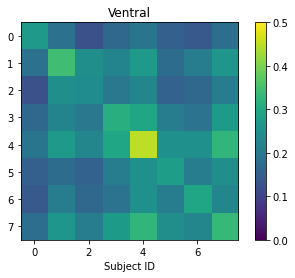

In [24]:
plt.imshow(
        corr_mat
    )
plt.clim(0,.5)
plt.title('Ventral')
plt.xlabel('Subject ID')
plt.colorbar()